# Isolating Model Components
If we want to we can examine individual model components in a notebook. Here we'll look at the tracer advection

First we set up the environment

In [1]:
nx = 20
ny = 20
nz = 79
nhalo = 3
backend = "numpy"

import ipyparallel as ipp

layout = (1, 1)
ntiles = 6
# spinup cluster of MPI-workers
num_ranks = ntiles * layout[0] * layout[1]

tracer_center = (0, 0)
test_case = "b"
timestep = 900.0

cluster = ipp.Cluster(engines="mpi", n=num_ranks).start_and_connect_sync()

# broadcast configuration to all workers
ar = cluster[:].push(
    {
        "ntiles": ntiles,
        "nx": nx,
        "ny": ny,
        "nz": nz,
        "nhalo": nhalo,
        "layout": layout,
        "backend": backend,
        "tracer_center": tracer_center,
        "test_case": test_case,
        "timestep": timestep
    }
)

# start executing cells on the workers in parallel from here on
%autopx

Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|█████████████████████████████████████████| 6/6 [00:05<00:00,  1.07engine/s]
%autopx enabled


Now in an mpi context we can set up and run the advection scheme:

In [2]:
from mpi4py import MPI

mpi_comm = MPI.COMM_WORLD
mpi_rank = mpi_comm.Get_rank()

In [3]:
import functions as func
import importlib
import copy as cp
import importlib

importlib.reload(func)

nz = 1
if nz == 1:
    single_layer = True
else:
    single_layer = False

namelist_dict = func.store_namelist_variables(locals())
dimensions = func.define_dimensions(namelist_dict)


domain_configuration = func.configure_domain(mpi_comm, dimensions, single_layer=single_layer)

initial_state = func.create_initial_state_advection(
    domain_configuration["metric_terms"], dimensions, tracer_center, test_case
)

stencil_configuration = func.configure_stencil(domain_configuration, backend=backend)
stencil_configuration["quantity_factory"] = domain_configuration["quantity_factory"]

tracer_advection_data, tracer_advection = func.prepare_everything_for_advection(
    stencil_configuration, initial_state, dimensions, timestep
)

tracer_advection_data_initial = cp.deepcopy(tracer_advection_data)

tracer_state = [cp.deepcopy(tracer_advection_data_initial["tracers"]["tracer"])]

nSteps = 20
for step in range(nSteps):
    tracer_advection_data = func.run_advection_step_with_reset(
        tracer_advection_data_initial, tracer_advection_data, tracer_advection
    )

    tracer_state.append(cp.deepcopy(tracer_advection_data["tracers"]["tracer"]))

%px:   0%|                                             | 0/6 [00:01<?, ?tasks/s]

[output:3]

%px:   0%|                                             | 0/6 [00:01<?, ?tasks/s]

[output:5]

%px:   0%|                                             | 0/6 [00:01<?, ?tasks/s]

[output:4]

%px:   0%|                                             | 0/6 [00:01<?, ?tasks/s]

[output:0]

%px:   0%|                                             | 0/6 [00:01<?, ?tasks/s]

[output:1]

%px:   0%|                                             | 0/6 [00:01<?, ?tasks/s]

[output:2]

%px:   0%|                                             | 0/6 [00:02<?, ?tasks/s]

[stdout:3] 2024-01-24 17:45:02|INFO|rank 3|pace.util.logging:Constant selected: ConstantVersions.GFS


[stdout:5] 2024-01-24 17:45:02|INFO|rank 5|pace.util.logging:Constant selected: ConstantVersions.GFS


[stdout:0] 2024-01-24 17:45:02|INFO|rank 0|pace.util.logging:Constant selected: ConstantVersions.GFS


[stdout:4] 2024-01-24 17:45:02|INFO|rank 4|pace.util.logging:Constant selected: ConstantVersions.GFS


%px:   0%|                                             | 0/6 [00:02<?, ?tasks/s]

[stdout:1] 2024-01-24 17:45:02|INFO|rank 1|pace.util.logging:Constant selected: ConstantVersions.GFS


%px:   0%|                                             | 0/6 [00:02<?, ?tasks/s]

[stdout:2] 2024-01-24 17:45:03|INFO|rank 2|pace.util.logging:Constant selected: ConstantVersions.GFS


%px:   0%|                                             | 0/6 [00:04<?, ?tasks/s]

[stderr:2] /usr/local/lib/python3.8/dist-packages/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


[stderr:5] /usr/local/lib/python3.8/dist-packages/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


%px: 100%|█████████████████████████████████████| 6/6 [00:16<00:00,  2.67s/tasks]


Now we can plot the difference between the initial and final state and see that our tracer has been advected east as expected:

[output:0]

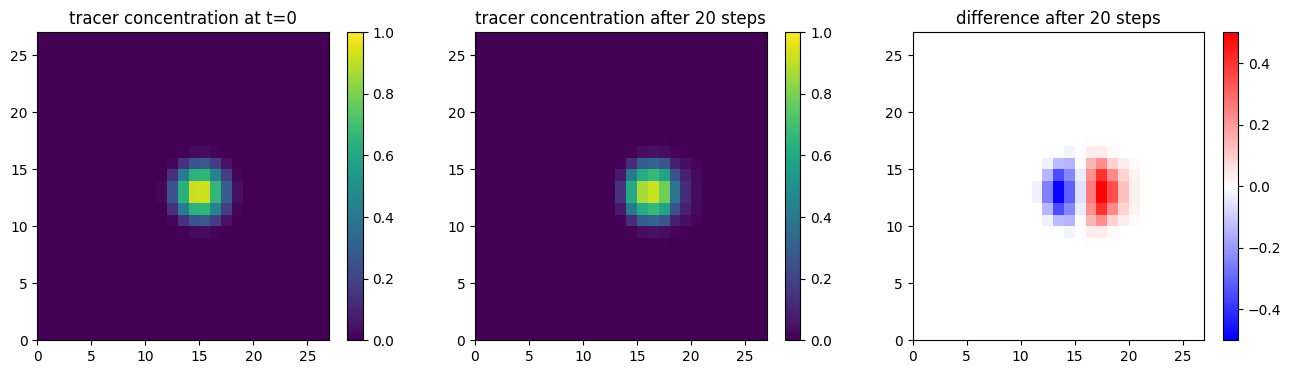

In [4]:
import matplotlib.pyplot as plt

if mpi_rank == 0:
    fig = plt.figure(figsize=(16, 4))
    fig.patch.set_facecolor("white")
    ax_before = fig.add_subplot(131)
    ax_after = fig.add_subplot(132)
    ax_diff = fig.add_subplot(133)

    f1 = ax_before.pcolormesh(
        tracer_state[0].data[:, :, 0].T, vmin=-0, vmax=1, cmap="viridis"
    )
    plt.colorbar(f1, ax=ax_before)
    f2 = ax_after.pcolormesh(
        tracer_state[-1].data[:, :, 0].T, vmin=-0, vmax=1, cmap="viridis"
    )
    plt.colorbar(f2, ax=ax_after)
    f3 = ax_diff.pcolormesh(
        (tracer_state[-1].data[:, :, 0] - tracer_state[0].data[:, :, 0]).T,
        vmin=-0.5,
        vmax=0.5,
        cmap="bwr",
    )
    plt.colorbar(f3, ax=ax_diff)

    ax_before.set_title("tracer concentration at t=0")
    ax_after.set_title("tracer concentration after %s steps" % nSteps)
    ax_diff.set_title("difference after %s steps" % nSteps)
    plt.show()